# Twitter Sentiment Analysis

In [1]:
!pip install gensim --upgrade
!pip install keras --upgrade
!pip install pandas --upgrade

    100% |████████████████████████████████| 24.2MB 1.9MB/s eta 0:00:01
    100% |████████████████████████████████| 122kB 31.5MB/s ta 0:00:01
  Running setup.py bdist_wheel for smart-open ... done
  Stored in directory: /root/.cache/pip/wheels/25/6c/db/7dcb26f19fb260c5629af85ed1c8ef9641143444fc7ec1fa08
Successfully built smart-open
  Found existing installation: smart-open 1.7.1
    Uninstalling smart-open-1.7.1:
      Successfully uninstalled smart-open-1.7.1
  Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0
You are using pip version 18.1, however version 20.2b1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
  Found existing installation: Keras 2.2.4
    Uninstalling Keras-2.2.4:
      Successfully uninstalled Keras-2.2.4
You are using pip version 18.1, however version 20.2b1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
    100% |███

In [5]:
!pip install --upgrade pip
!pip install tensorflow

# DataFrame
import pandas as pd

# Matplot
import matplotlib.pyplot as plt
%matplotlib inline

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer

# Keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM
from tensorflow.keras import utils
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

# nltk
import nltk
from nltk.corpus import stopwords
from  nltk.stem import SnowballStemmer

# Word2vec
import gensim

# Utility
import re
import numpy as np
import os
from collections import Counter
import logging
import time
import pickle
import itertools

# Set log
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

Requirement already up-to-date: pip in /opt/conda/lib/python3.6/site-packages (20.1.1)


In [6]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

### Settings

In [7]:
# DATASET
DATASET_COLUMNS = ["target", "ids", "date", "flag", "user", "text"]
DATASET_ENCODING = "ISO-8859-1"
TRAIN_SIZE = 0.8

# TEXT CLENAING
TEXT_CLEANING_RE = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

# WORD2VEC 
W2V_SIZE = 300
W2V_WINDOW = 7
W2V_EPOCH = 32
W2V_MIN_COUNT = 10

# KERAS
SEQUENCE_LENGTH = 300
EPOCHS = 8
BATCH_SIZE = 1024

# SENTIMENT
POSITIVE = "POSITIVE"
NEGATIVE = "NEGATIVE"
NEUTRAL = "NEUTRAL"
SENTIMENT_THRESHOLDS = (0.4, 0.7)

# EXPORT
KERAS_MODEL = "model.h5"
WORD2VEC_MODEL = "model.w2v"
TOKENIZER_MODEL = "tokenizer.pkl"
ENCODER_MODEL = "encoder.pkl"

### Read Dataset

### Dataset details
* **target**: the polarity of the tweet (0 = negative, 2 = neutral, 4 = positive)
* **ids**: The id of the tweet ( 2087)
* **date**: the date of the tweet (Sat May 16 23:58:44 UTC 2009)
* **flag**: The query (lyx). If there is no query, then this value is NO_QUERY.
* **user**: the user that tweeted (robotickilldozr)
* **text**: the text of the tweet (Lyx is cool)

In [8]:
df = pd.read_csv('twitter data.csv', encoding =DATASET_ENCODING , names=DATASET_COLUMNS)

Open file: ../input/training.1600000.processed.noemoticon.csv


In [9]:
print("Dataset size:", len(df))

Dataset size: 1600000


In [10]:
df.head(5)

ImportError: cannot import name 'is_url'

   target                        ...                                                                       text
0       0                        ...                          @switchfoot http://twitpic.com/2y1zl - Awww, t...
1       0                        ...                          is upset that he can't update his Facebook by ...
2       0                        ...                          @Kenichan I dived many times for the ball. Man...
3       0                        ...                            my whole body feels itchy and like its on fire 
4       0                        ...                          @nationwideclass no, it's not behaving at all....

[5 rows x 6 columns]

### Map target label to String
* **0** -> **NEGATIVE**
* **2** -> **NEUTRAL**
* **4** -> **POSITIVE**

In [11]:
decode_map = {0: "NEGATIVE", 2: "NEUTRAL", 4: "POSITIVE"}
def decode_sentiment(label):
    return decode_map[int(label)]

In [12]:
%%time
df.target = df.target.apply(lambda x: decode_sentiment(x))

CPU times: user 1.06 s, sys: 42.8 ms, total: 1.11 s
Wall time: 1.11 s


Text(0.5,1,'Dataset labels distribuition')

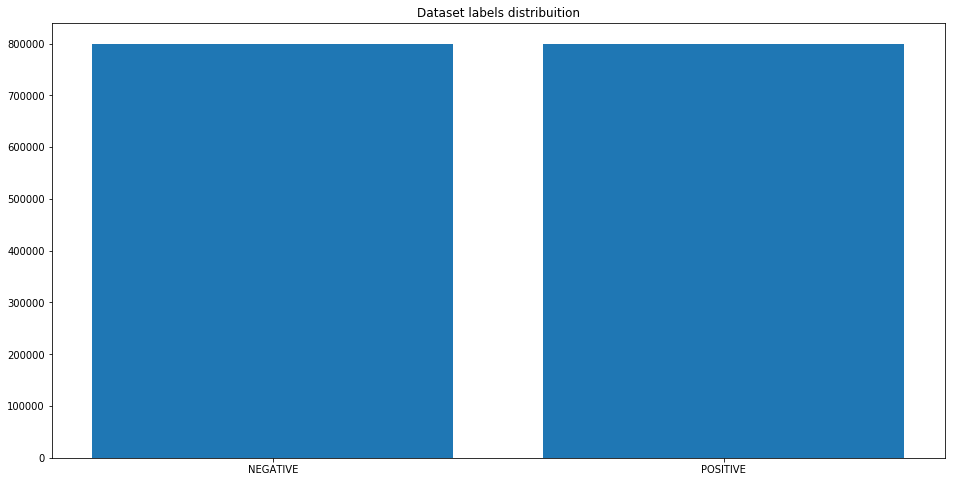

In [13]:
target_cnt = Counter(df.target)

plt.figure(figsize=(16,8))
plt.bar(target_cnt.keys(), target_cnt.values())
plt.title("Dataset labels distribuition")

### Pre-Process dataset

In [14]:
stop_words = stopwords.words("english")
stemmer = SnowballStemmer("english")

In [15]:
def preprocess(text, stem=False):
    # Remove link,user and special characters
    text = re.sub(TEXT_CLEANING_RE, ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)

In [16]:
%%time
df.text = df.text.apply(lambda x: preprocess(x))

CPU times: user 1min 7s, sys: 145 ms, total: 1min 7s
Wall time: 1min 7s


### Split train and test

In [17]:
df_train, df_test = train_test_split(df, test_size=1-TRAIN_SIZE, random_state=42)
print("TRAIN size:", len(df_train))
print("TEST size:", len(df_test))

TRAIN size: 1280000
TEST size: 320000


### Word2Vec 

In [18]:
%%time
documents = [_text.split() for _text in df_train.text] 

CPU times: user 3.73 s, sys: 353 ms, total: 4.08 s
Wall time: 4.28 s


In [19]:
w2v_model = gensim.models.word2vec.Word2Vec(size=W2V_SIZE, 
                                            window=W2V_WINDOW, 
                                            min_count=W2V_MIN_COUNT, 
                                            workers=8)

In [20]:
w2v_model.build_vocab(documents)

2020-07-18 03:20:23,461 : INFO : collecting all words and their counts
2020-07-18 03:20:23,463 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2020-07-18 03:20:23,490 : INFO : PROGRESS: at sentence #10000, processed 72565 words, keeping 14005 word types
2020-07-18 03:20:23,515 : INFO : PROGRESS: at sentence #20000, processed 144393 words, keeping 21587 word types
2020-07-18 03:20:23,542 : INFO : PROGRESS: at sentence #30000, processed 215826 words, keeping 27541 word types
2020-07-18 03:20:23,567 : INFO : PROGRESS: at sentence #40000, processed 288271 words, keeping 32764 word types
2020-07-18 03:20:23,594 : INFO : PROGRESS: at sentence #50000, processed 359772 words, keeping 37587 word types
2020-07-18 03:20:23,623 : INFO : PROGRESS: at sentence #60000, processed 431431 words, keeping 42198 word types
2020-07-18 03:20:23,651 : INFO : PROGRESS: at sentence #70000, processed 503103 words, keeping 46458 word types
2020-07-18 03:20:23,678 : INFO : PROGRESS: at s

In [21]:
words = w2v_model.wv.vocab.keys()
vocab_size = len(words)
print("Vocab size", vocab_size)

Vocab size 30369


In [22]:
%%time
w2v_model.train(documents, total_examples=len(documents), epochs=W2V_EPOCH)

2020-07-18 03:20:28,447 : INFO : training model with 8 workers on 30369 vocabulary and 300 features, using sg=0 hs=0 sample=0.001 negative=5 window=7
2020-07-18 03:20:29,517 : INFO : EPOCH 1 - PROGRESS: at 3.58% examples, 277473 words/s, in_qsize 14, out_qsize 2
2020-07-18 03:20:30,563 : INFO : EPOCH 1 - PROGRESS: at 7.93% examples, 308803 words/s, in_qsize 15, out_qsize 0
2020-07-18 03:20:31,626 : INFO : EPOCH 1 - PROGRESS: at 12.06% examples, 312103 words/s, in_qsize 14, out_qsize 2
2020-07-18 03:20:32,663 : INFO : EPOCH 1 - PROGRESS: at 16.16% examples, 315553 words/s, in_qsize 15, out_qsize 0
2020-07-18 03:20:33,671 : INFO : EPOCH 1 - PROGRESS: at 19.19% examples, 302336 words/s, in_qsize 13, out_qsize 2
2020-07-18 03:20:34,792 : INFO : EPOCH 1 - PROGRESS: at 23.95% examples, 310770 words/s, in_qsize 14, out_qsize 2
2020-07-18 03:20:35,816 : INFO : EPOCH 1 - PROGRESS: at 28.72% examples, 320787 words/s, in_qsize 15, out_qsize 0
2020-07-18 03:20:36,838 : INFO : EPOCH 1 - PROGRESS: a

CPU times: user 21min 10s, sys: 6.64 s, total: 21min 17s
Wall time: 12min


(263118379, 295270528)

In [23]:
w2v_model.most_similar("love")

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.
2020-07-18 03:32:28,782 : INFO : precomputing L2-norms of word weight vectors


[('luv', 0.573813796043396),
 ('loves', 0.5578497648239136),
 ('loved', 0.5381397604942322),
 ('amazing', 0.5114535093307495),
 ('adore', 0.5087866187095642),
 ('looove', 0.4962613880634308),
 ('awesome', 0.4662848114967346),
 ('loveee', 0.4556906223297119),
 ('lovee', 0.44604575634002686),
 ('loooove', 0.44025370478630066)]

### Tokenize Text

In [24]:
%%time
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_train.text)

vocab_size = len(tokenizer.word_index) + 1
print("Total words", vocab_size)

Total words 290419
CPU times: user 27.2 s, sys: 187 ms, total: 27.4 s
Wall time: 27.4 s


In [25]:
%%time
x_train = pad_sequences(tokenizer.texts_to_sequences(df_train.text), maxlen=SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(df_test.text), maxlen=SEQUENCE_LENGTH)

CPU times: user 44.5 s, sys: 942 ms, total: 45.5 s
Wall time: 45.7 s


### Label Encoder 

In [26]:
labels = df_train.target.unique().tolist()
labels.append(NEUTRAL)
labels

['POSITIVE', 'NEGATIVE', 'NEUTRAL']

In [27]:
encoder = LabelEncoder()
encoder.fit(df_train.target.tolist())

y_train = encoder.transform(df_train.target.tolist())
y_test = encoder.transform(df_test.target.tolist())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train",y_train.shape)
print("y_test",y_test.shape)

y_train (1280000, 1)
y_test (320000, 1)


In [28]:
print("x_train", x_train.shape)
print("y_train", y_train.shape)
print()
print("x_test", x_test.shape)
print("y_test", y_test.shape)

x_train (1280000, 300)
y_train (1280000, 1)

x_test (320000, 300)
y_test (320000, 1)


In [29]:
y_train[:10]

array([[1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1]])

### Embedding layer

In [30]:
embedding_matrix = np.zeros((vocab_size, W2V_SIZE))
for word, i in tokenizer.word_index.items():
  if word in w2v_model.wv:
    embedding_matrix[i] = w2v_model.wv[word]
print(embedding_matrix.shape)

(290419, 300)


In [31]:
embedding_layer = Embedding(vocab_size, W2V_SIZE, weights=[embedding_matrix], input_length=SEQUENCE_LENGTH, trainable=False)

### Build Model

In [32]:
model = Sequential()
model.add(embedding_layer)
model.add(Dropout(0.5))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 300, 300)          87125700  
_________________________________________________________________
dropout (Dropout)            (None, 300, 300)          0         
_________________________________________________________________
lstm (LSTM)                  (None, 100)               160400    
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 87,286,201
Trainable params: 160,501
Non-trainable params: 87,125,700
_________________________________________________________________


### Compile model

In [33]:
model.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

### Callbacks

In [34]:
callbacks = [ ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
              EarlyStopping(monitor='val_acc', min_delta=1e-4, patience=5)]

### Train

In [35]:
%%time
history = model.fit(x_train, y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_split=0.1,
                    verbose=1,
                    callbacks=callbacks)

Train on 1152000 samples, validate on 128000 samples
Epoch 1/2
1152000/1152000 [==============================] - 707s 614us/step - loss: 0.5047 - acc: 0.7500 - val_loss: 0.4660 - val_acc: 0.7787
Epoch 2/2
1152000/1152000 [==============================] - 708s 614us/step - loss: 0.4791 - acc: 0.7673 - val_loss: 0.4599 - val_acc: 0.7840
CPU times: user 30min 21s, sys: 1min 40s, total: 32min 2s
Wall time: 23min 36s


### Evaluate

In [36]:
%%time
score = model.evaluate(x_test, y_test, batch_size=BATCH_SIZE)
print()
print("ACCURACY:",score[1])
print("LOSS:",score[0])

320000/320000 [==============================] - 73s 229us/step

ACCURACY: 0.784503125
LOSS: 0.4589654022216797
CPU times: user 1min 40s, sys: 8.15 s, total: 1min 48s
Wall time: 1min 13s


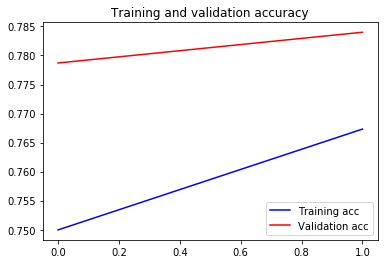

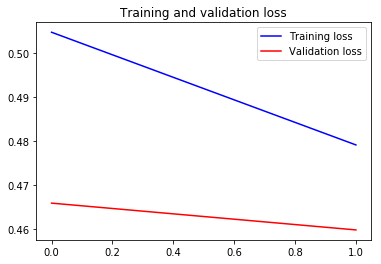

In [37]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

### Predict

In [39]:
def decode_sentiment(score, include_neutral=True):
    if include_neutral:        
        label = NEUTRAL
        if score <= SENTIMENT_THRESHOLDS[0]:
            label = NEGATIVE
        elif score >= SENTIMENT_THRESHOLDS[1]:
            label = POSITIVE

        return label
    else:
        return NEGATIVE if score < 0.5 else POSITIVE

In [40]:
def predict(text, include_neutral=True):
    start_at = time.time()
    # Tokenize text
    x_test = pad_sequences(tokenizer.texts_to_sequences([text]), maxlen=SEQUENCE_LENGTH)
    # Predict
    score = model.predict([x_test])[0]
    # Decode sentiment
    label = decode_sentiment(score, include_neutral=include_neutral)

    return {"label": label, "score": float(score),
       "elapsed_time": time.time()-start_at}  

In [45]:
'''
!pip install gdown
#!gdown https://drive.google.com/file/d/1E7T6_AK7ZOC037YpmUvzxd9bYT1L2LCT/view?usp=sharing
!gdown https://drive.google.com/uc?id=1E7T6_AK7ZOC037YpmUvzxd9bYT1L2LCT
'''
try:
    from PIL import Image
except ImportError:
    import Image
import pytesseract

# If you don't have tesseract executable in your PATH, include the following:
pytesseract.pytesseract.tesseract_cmd = r'C:\Users\ACER\AppData\Local\Tesseract-OCR\tesseract.exe'
# Example tesseract_cmd = r'C:\Program Files (x86)\Tesseract-OCR\tesseract'

import pandas as pd
img_data = pd.read_csv('Test.csv')


df = pd.DataFrame(img_data)

content = []

for i in df['Filename']:
    con = pytesseract.image_to_string(Image.open('Dataset/'+i))
    content.append(con)

df['Content'] = content

df = df.drop(columns=['Filename', 'Category',])

df.to_csv(r'my_content.csv', index = False)

Downloading...
From: https://drive.google.com/uc?id=1E7T6_AK7ZOC037YpmUvzxd9bYT1L2LCT
To: /kaggle/working/my_content.csv
100%|██████████████████████████████████████| 18.2k/18.2k [00:00<00:00, 20.6MB/s]


In [58]:
df1 = pd.read_csv('my_content.csv', encoding =DATASET_ENCODING , names=DATASET_COLUMNS)

In [63]:
df1.columns

Index(['Filename', 'Content'], dtype='object')

In [67]:
Category = []
for i in df1['Content']:
    i = preprocess(i)
    Category.append(predict(i)['label'])

In [69]:
df1['Category'] = Category

In [70]:
df1 = df1.drop(columns=['Content'])

ImportError: cannot import name 'is_url'

         Filename  Category
1    Test1001.jpg  POSITIVE
2    Test1012.jpg   NEUTRAL
3    Test1022.jpg  POSITIVE
4    Test1071.jpg  POSITIVE
5    Test1122.jpg   NEUTRAL
6    Test1161.jpg  POSITIVE
7    Test1199.jpg  POSITIVE
8    Test1229.jpg   NEUTRAL
9    Test1240.jpg  POSITIVE
10   Test1271.jpg  POSITIVE
11   Test1279.jpg  POSITIVE
12   Test1290.jpg  POSITIVE
13   Test1353.jpg  POSITIVE
14   Test1359.jpg  POSITIVE
15   Test1615.jpg   NEUTRAL
16   Test1620.jpg  POSITIVE
17   Test1634.jpg  POSITIVE
18   Test1644.jpg   NEUTRAL
19   Test1717.jpg  POSITIVE
20   Test1724.jpg  POSITIVE
21   Test1743.jpg  POSITIVE
22   Test1767.jpg  POSITIVE
23   Test1776.jpg  POSITIVE
24   Test1785.jpg   NEUTRAL
25   Test1788.jpg  POSITIVE
26   Test1803.jpg  POSITIVE
27   Test1818.jpg  POSITIVE
28   Test1837.jpg   NEUTRAL
29   Test1856.jpg  POSITIVE
30   Test1872.jpg  POSITIVE
..            ...       ...
210   Test198.jpg  NEGATIVE
211   Test201.jpg  POSITIVE
212   Test204.jpg  POSITIVE
213   Test206.jpg  P

In [106]:
img_data = pd.read_csv('Test.csv')
df = pd.DataFrame(img_data)

df1['Filename'] = df['Filename']

a = df1['Category']
df1 = df1.drop(columns=['Category'])
df1['Category'] = a

In [ ]:
df1['Category'] = df1['Category'].str.capitalize()
df1['Category'] = df1['Category'].replace(['Neutral'],'Random')

In [105]:
df1.to_csv('Submission.csv', index=None)

ImportError: cannot import name 'get_compression_method'

### Confusion Matrix

In [ ]:
%%time
y_pred_1d = []
y_test_1d = list(df_test.target)
scores = model.predict(x_test, verbose=1, batch_size=8000)
y_pred_1d = [decode_sentiment(score, include_neutral=False) for score in scores]

In [ ]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=22)
    plt.yticks(tick_marks, classes, fontsize=22)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=25)
    plt.xlabel('Predicted label', fontsize=25)

In [ ]:
%%time

cnf_matrix = confusion_matrix(y_test_1d, y_pred_1d)
plt.figure(figsize=(12,12))
plot_confusion_matrix(cnf_matrix, classes=df_train.target.unique(), title="Confusion matrix")
plt.show()

### Classification Report

In [ ]:
print(classification_report(y_test_1d, y_pred_1d))

### Accuracy Score

In [ ]:
accuracy_score(y_test_1d, y_pred_1d)

### Save model

In [ ]:
model.save(KERAS_MODEL)
w2v_model.save(WORD2VEC_MODEL)
pickle.dump(tokenizer, open(TOKENIZER_MODEL, "wb"), protocol=0)
pickle.dump(encoder, open(ENCODER_MODEL, "wb"), protocol=0)